<a href="https://colab.research.google.com/github/tchufnagel/group-code/blob/main/Kolsky.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import csv
import polars as pl
import scipy as sp
from scipy.signal import savgol_filter
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

%matplotlib inline

In [ ]:
def readAndFormatData(csv_file):
    """
    Reads the given csv file and converts the data to a Polars/pandas dataframe.

    Args:
        csv_file: string
            Path to the csv file that contains the Kolsky bar strain gage(s) signal data. This parameter will be deprecated in future versions.

    Returns:
        kb: Polars/pandas dataframe
            The Kolsky bar strain gage(s) signal data in a Python manipulative format.
    """
    # cur_path = os.path.dirname(__file__)
    # new_path = os.path.relpath('../CHESS JUN2023/18-53-35.txt', cur_path)
    # for f_name in os.listdir('some_directory'):
    #     if f_name.endswith('.csv'):
            # print(f_name)
    drive.mount('/content/drive/')
    with open(csv_file, 'r') as f:
       data = f.read()
       kb = pl.read_csv(csv_file, has_header=False, new_columns=['time', 'incident', 'transmitted', 'reflected'])
       return kb


In [ ]:
kolsky_data = readAndFormatData('/content/drive/My Drive/Kolsky_bar_Westerly_granite#4_20240220 _004_cleaned.csv')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
def filterData_savgol(data, columns, window_length, polyorder):
    """
    Filters the data using the Savitsky-Golay technique. For more information, see https://eigenvector.com/wp-content/uploads/2020/01/SavitzkyGolay.pdf
    For a more in-depth discussion: https://inst.eecs.berkeley.edu/~ee123/sp14/docs/SGFilter.pdf
    and see this: http://www.phys.uri.edu/nigh/NumRec/bookfpdf/f14-8.pdf
    window_length (window size) determines the amount of sample data points used for filtering in each batch.
    polyorder (Polynomial order) determines the degree of derivative used to smooth the data (recommend 3 or less).

    Args:
        data: Polars/pandas dataframe
            Contains the Kolsky bar strain gage(s) signal data.
        columns: list
            Contains the columns that the filter should be applied. Column names need to be strings.
        window_length: int
            Sample interval for which the data should be evaluated to create a new, filtered data point.
        polyorder: int
            Degree of the polynomial used to fit the data over the window length.

    Returns:
        data: Polars/pandas dataframe
            Contains the filtered data.
    """
    for column in columns:
        data = data.with_columns([pl.col(column).map(lambda x: savgol_filter(x.to_numpy(), window_length, polyorder)).explode()])

    return data

In [ ]:
#This part of the code puts the Kolsky Data through a Savitzky-Goulay filter. This allows us to find the differential of our function should we need to use it
#identifying peaks later when we automate the system
kolsky_data_filtered = filterData_savgol(kolsky_data, ['incident', 'reflected', 'transmitted'], 11, 2)


<ipython-input-64-e57185b3d5b5>:24: DeprecationWarning: `map` is deprecated. It has been renamed to `map_batches`.
  data = data.with_columns([pl.col(column).map(lambda x: savgol_filter(x.to_numpy(), window_length, polyorder)).explode()])


In [ ]:
def kolskyStressStrain(kolsky_data, specimen_length, specimen_depth, specimen_width=None, specimen_shape='cylinder', gage_factor=2.00, bar_diameter=0.00635, elastic_modulus=210e9, rho=8100):
    """
    Reads the given Polars/pandas dataframe and calculates and returns stress, strain, and energy values.

    Args:
        kolsky_data: Polars/pandas dataframe
            The Kolsky bar strain gage(s) signal data in a Python manipulative format.
        specimen_length: float
            Edge length for a cube. If the sample is a cylinder, it is assumed to be its diameter.
        specimen_depth: float
        specimen_width: None or float
            Only used if 'specimen_type' is other than a cylinder.
        specimen_shape: string
            Only 'cube' or 'cylinder' is allowed.
        gage_factor: float
            Strain gage factor. Determined by manufacturer and model.
        bar_diameter: float
        elastic_modulus: int
        rho: int

    Returns:
        voltage_signal: list
        time: list
        strain: list
        stress: list
        energy: list
    """
    # Given Parameters (in meters)
    # incident_bar_length=0.9144    # Not used, only for recordkeeping
    # transmitted_bar_length=0.508    # Not used, only for recordkeeping
    bar_area = np.pi * (bar_diameter/2)**2 # Incident bar area. The rest of the code assumes that the incident bar, transmitted bar, and striker all have the same diameter
    wave_speed = (elastic_modulus / rho)**0.5 #speed of sound within the incident bar
    load_time = (2 * specimen_depth) / wave_speed
    strain_convert_from_voltage = 400e-6   # 1 mV/V per 2000 micro-strain. 5V multiplier. Multiply strain_convert_from_voltage to received data in csv to get instantaneous strain at given time

    if specimen_shape == 'cube':
        specimen_area = specimen_length * specimen_width
        # volume = specimen_length * specimen_width * specimen_depth
    if specimen_shape == 'cylinder':
        specimen_area = np.pi * (specimen_length/2)**2  # Assumes diameter is being used for specimen_length
        # volume = np.pi * specimen_length**2 * specimen_depth
    elif specimen_shape != 'cube' and specimen_type != 'cylinder':
        print('Not a valid shape! Exiting...')
        return

    # Reading the data from the file
    time = kolsky_data['time']
    strain_incident_voltage = kolsky_data['incident']
    strain_transmitted_voltage = kolsky_data['transmitted']
    strain_reflected_voltage = kolsky_data['reflected']

    voltage_signal = [strain_incident_voltage, strain_transmitted_voltage, strain_reflected_voltage]

    strain_incident = 2 * strain_incident_voltage / (gage_factor) * strain_convert_from_voltage / 2 #2 = excitation  #equation 1.42 from Wayne Chen's book (page 22)
    strain_transmitted = 2 * strain_transmitted_voltage / (gage_factor) * strain_convert_from_voltage / 2 #2 = excitation #equation 1.42 from Wayne Chen's book (page 22)
    strain_reflected = 2 * strain_reflected_voltage / (gage_factor) * strain_convert_from_voltage / 2 #2 = excitation #equation 1.42 from Wayne Chen's book (page 22)
    specimen_strain_rate = wave_speed /specimen_depth * abs(strain_incident + strain_reflected + strain_transmitted) ##CheckCheckCheckCheckCheckCheckCheckCheckCheckCheckCheckCheckCheckCheck
    strain_time = (np.arange(0, len(specimen_strain_rate) + 1)) * (time[1] - time[0])

    # Determines the incremental strain per step of the process.
    incremental_strain = np.diff(time, prepend=strain_time[0]) * specimen_strain_rate
    specimen_strain_total = np.cumsum(incremental_strain)

    strain = [strain_incident, strain_transmitted, strain_reflected, specimen_strain_rate, strain_time, incremental_strain, specimen_strain_total]

    # Separates the stresses of the system from the left and right side of the sample. The two sides should balance out.
    stress_left = abs(elastic_modulus*(strain_incident + strain_reflected)) #left and right are relative to the viewer: left is the side where the incident bar strikes the sample, right is where the wave is transmitted
    stress_right = abs(elastic_modulus*(strain_transmitted)) #left and right are relative to the viewer: left is the side where the incident bar strikes the sample, right is where the wave is transmitted
    stress_time_left = np.arange(1, len(stress_left) + 1) #left and right are relative to the viewer: left is the side where the incident bar strikes the sample, right is where the wave is transmitted
    stress_time_right = np.arange(1, len(stress_right) + 1) #left and right are relative to the viewer: left is the side where the incident bar strikes the sample, right is where the wave is transmitted
    specimen_stress_left = stress_left * (bar_area/specimen_area)
    specimen_stress_right = stress_right * (bar_area/specimen_area)

    stress = [stress_left, stress_right, stress_time_left, stress_time_right, specimen_stress_left, specimen_stress_right]

    strain_energy = 0.5 * specimen_area * wave_speed * load_time * elastic_modulus * (strain_incident**2)
    kinetic_energy = 0.5 * rho * specimen_area * (wave_speed**3) * load_time * (strain_incident**2)
    total_energy = strain_energy + kinetic_energy

    energy = [strain_energy, kinetic_energy, total_energy]

    return voltage_signal, time, strain, stress, energy, specimen_strain_rate

In [ ]:
voltage_signal, time, strain, stress, energy, specimen_strain_rate = kolskyStressStrain(kolsky_data, specimen_shape='cylinder', specimen_length=0.00244, specimen_width=0.00245, specimen_depth=0.00250)

In [ ]:
def trueStressStrain(eng_stress, eng_strain, eng_strain_rate, specimen_stress):
    true_strain = -np.log(1 - eng_strain)
    true_strain_rate = eng_strain_rate / (1 - eng_strain)
    true_stress = specimen_stress * (1 - eng_strain)
    return true_stress_strain

In [ ]:
# # dispersionLib.py
# # Dispersion Correction via Python
# # @author: Sasha
#  # (received via personal correspondence from A.M. Bragov)
# # Created on Mon Feb 07 15:42:59 2011
# # See Bragov et al., "Dispersion correction in split-Hopkinson pressure bar: theoretical and experimental analysis." Continuum Mechanics and Thermodynamics 34 (2022) 895-907, (https://doi.org/10.1007/s00161-019-00776-0) for more info on dispersion correction.
# # Many comments added by B.M. Morrow (for clarity), 2020.

# import mpmath as mm
# import numpy as np
# import json

# class barWithDispersion:
#     """Dispersion Correction Class for Kolsky Bar.
#     Methodology: Perform dispersion shift of a pulse to obtain an explicit dependence of the wave number ξ, AKA xi/ksi, on frequency omega.
#     This method is based on the direct solution of the Pochhammer-Chree frequency equation. Functional dependence ksi(omega) is determined by solving the frequency (equation 1 in paper).
#     The algorithm for solving this equation is as follows:
#         1. The interval [0, omegamax] is selected to solve the given equation
#         2. The step delta omega is set
#         3. Value ksi_n, satisfying Eq. (1), is numerically determined for frequency omega_n = omega_n-1 + delta omega
#         4. The linear extrapolation of the last two solutions is chosen as the initial approximation for ksi_n:
#           (ksi_n)^0 = ksi_(n-1) + (ksi_(n-1) - ksi_(n-2))/(omega_(n-1) - omega_(n-2))*(omega_n - omega_(n-1))
#         5. If the solution with given accuracy could not be found, then step (delta omega) is to be divided into half and steps 3 and 4 are to be repeated.

#     Usage: barWithDispersion(E = 194310000000, rho = 8082., nu = 0.31025, r0 = (d_bar_i_equiv/2)/1000)

#     Input Definitions:
#         d - bar diameter (m)
#         rho - bar density (kg/m^3)
#         youngs_modulus - Young's modulus (Pa)
#         nu - Poisson's ratio
#         cb = 'bar' velocity (m/s)"""

#     def __init__(self, d0 = 6.35e-3, rho = 8100., youngs_modulus = 210e9, nu = 0.3):
#         self.r0 = d0/2.                     # bar radius (m)
#         self.rho = rho                    # density (kg/m^3)
#         self.youngs_modulus = youngs_modulus      # Young's Modulus (Pa)
#         self.nu = nu                      # Poisson ratio
#         self.l = youngs_modulus*nu/(1+nu)/(1-2*nu)     # lambda (Lame's first parameter)
#         self.mu = youngs_modulus/2./(1+nu)             # shear modulus (mu or G) (Lame's second parameter)
#         self.cb = np.sqrt(youngs_modulus/rho)          # 'bar' velocity (m/s); units reduce from Pa/(kg/m^3) to m/s.
#         self.cs = np.sqrt(self.mu/rho)    # shear velocity
#         self.cl = np.sqrt((self.l+2*self.mu)/rho)   # velocity of longitudinal waves (P-waves) (m/s)
#         self.cr = (0.862+1.14*nu)/(1+nu)*self.cs      # velocity of Raleigh waves (dispersionless)

#     def f(self, ksi, omega):    # function relateing harmonic phase velocity xi and frequency omega
#         # Remember: ksi is lowercase greek letter xi ("ksi"), not a unit of pressure
#         alpha_sq = self.rho*omega**2/(self.l + 2*self.mu) - ksi**2  # Alpha squared in Pochhammer-Chree (P-C) equation
#         beta_sq = self.rho*omega**2/self.mu - ksi**2  # Beta squared in P-C eq
#         alpha = mm.sqrt(alpha_sq)
#         beta = mm.sqrt(beta_sq)
#         # The equation in Bragov 2022 is misprinted. The equations for alpha_sq and beta_sq differ between Bragov2022 and Bacon1998 by sign of ksi**2.
#         # Here we use the intent of Bragov et al.
#         freq = (
#             ((2 * alpha/self.r0) * (beta_sq + ksi**2) * mm.besselj(1, alpha * self.r0) * mm.besselj(1, beta * self.r0)) -
#             ((beta_sq - ksi**2)**2 * mm.besselj(0, alpha * self.r0) * mm.besselj(1, beta * self.r0)) -
#             (4 * ksi**2 * alpha * beta * mm.besselj(1, alpha * self.r0) * mm.besselj(0, beta*self.r0))
#             )
#         return abs(freq)

#     def solve(self, omegamax = 5e6, domega0 = lambda x: 10e3):
#         # this function numerically solves the Pochamer-Cree equation in the frequency range up to omegamax with domega increments
#         omega = [0]  # [0,1000.,2000.]
#         ksi = [0]  # [0,omega[1]/cb, omega[2]/cb]
#         domega = domega0(0)

#         while omega[-1] <= omegamax and domega > 1e-6 * domega0(omega[-1]):
#             xx = omega[-1] + domega
#             def q(x): return self.f(x, xx)/xx**2
#             try:
#                 if len(omega) >= 3:
#                     y0 = ((xx - omega[-2])/(omega[-1] - omega[-2]) * (ksi[-1] - ksi[-2]) + ksi[-2])
#                 else:
#                     y0 = 1.0
#                 y = mm.findroot(q, y0, solver='mnewton')
#                 omega.append(omega[-1] + domega)
#                 ksi.append(y.real)
#                 #print("Dispersion Correction; Converged:", omega[-1])  # we only need to know when there's an error (below)
#                 domega = domega0(omega[-1])
#             except ValueError:
#                 print(f'Dispersion Correction Not Converged: {omega[-1] + domega} {domega}')
#                 domega *= 0.5
#         self.ksi_omega = lambda x: np.interp(x, omega, ksi)
#         self.omega = np.array(omega)
#         self.ksi = np.array(ksi)
#         self.omegamax = max(self.omega)

# # These two properties are unused currently.
#     # @ property
#     # def cp_c0(self):
#     #     rez = []
#     #     for i in range(len(self.omega)):
#     #         if self.ksi[i] == 0:
#     #             rez.append(1)
#     #         else:
#     #             rez.append(self.omega[i]/self.ksi[i]/self.cb)
#     #     return rez

#     # @ property
#     # def r_l(self):
#     #     return self.r0*self.ksi/2/np.pi       # should this be 2*pi?

#     def Ksi(self, o):
#         if o <= self.omegamax:
#             return self.ksi_omega(o)
#         else:
#             return self.ksi[-1]+(o-self.omega[-1])/self.cr
# #            return self.ksi[-1]+(omega-omega[-1])/self.cr

#     def save(self, fname):
#         rez = {}
#         rez['r0'] = self.r0                # bar radius (m, I think)
#         rez['rho'] = self.rho              # density (g/cm^3)
#         rez['youngs_modulus'] = self.youngs_modulus                  # Young's Modulus
#         rez['nu'] = self.nu                # Poisson Ratio
#         rez['omegamax'] = self.omegamax    # maximum frequency?
#         rez['omega'] = list(map(float, self.omega))    # list of frequencies solved?
#         rez['ksi'] = list(map(float, self.ksi))        # list of ksi values corresponding to those omega values?
#         json.dump(rez, open(fname, 'w'))

#     def load(self, fname='', data=None):
#         if data == None:
#             rez = json.load(open(fname, 'r'))
#         else:
#             rez = json.loads(data)
#         self.r0 = rez['r0']                # bar radius? (m?)
#         self.rho = rez['rho']              # density (g/cm^3)
#         self.youngs_modulus = rez['youngs_modulus']                  # Young's Modulus
#         self.nu = rez['nu']                # Poisson Ratio
#         self.omegamax = rez['omegamax']    # Maximum frequecy
#         self.omega = np.array(rez['omega'])    # list of frequencies solved?
#         self.ksi = np.array(rez['ksi'])        # list of ksi values corresponding to those omega values?
#         self.l = self.youngs_modulus*self.nu/(1+self.nu)/(1-2*self.nu)      # lambda (Lame's first parameter)
#         self.mu = self.youngs_modulus/2./(1+self.nu)        # shear modulus (mu or G) (Lame's second parameter)
#         self.cb = np.sqrt(self.youngs_modulus/self.rho)     # 'bar' velocity
#         self.cs = np.sqrt(self.mu/self.rho)    # shear velocity (I'm assuming the "t" is for "transverse", because this is defo c_shear)
#         self.cl = np.sqrt((self.l+2*self.mu)/self.rho)         # velocity of P-wave (longitudinal)
#         self.cr = (0.862+1.14*self.nu)/(1+self.nu)*self.cs     # velocity of Raleigh waves (dispersionless)
#         self.ksi_omega = lambda x: np.interp(x, self.omega, self.ksi)   # interpolating between discrete values of ksi and omega?

#     def disp_shift_wave(self, t, y, dz, backshift = False):
#         # shifts the signal y(t) by the distance dz, taking into account the dispersion effect
#         fy = np.fft.rfft(y)
#         n = len(fy)
#         dz = -dz
#         omega = 2 * np.pi * np.arange(n) / max(t)
#         fy2 = []

#         for i in range(n):
#             fy2.append(np.exp(complex(0, self.Ksi(omega[i]) * dz)) * fy[i])

#         rez = np.fft.irfft(fy2).tolist()
#         if backshift:
#             dt = dz/self.cb
#             rez = self.simple_shift_wave(t, rez, dt)

#         rez = rez + [rez[-1]] * (len(y) - len(rez))
#         return rez

#     def simple_shift_wave(self, t, y, tshift):
#         dt = t[-1] - t[0]
#         tshift = tshift - np.floor(tshift/dt) * dt
#         dt = t[1] - t[0]
#         n = int(np.round(tshift/dt))
#         if isinstance(y, np.ndarray):
#             y = y.tolist()
#         return y[-n:]+y[:-n]

# if __name__ == '__main__':
#     import matplotlib.pylab as plt
#     c = barWithDispersion(youngs_modulus=210e9, rho=8100, nu=0.3, d0=6.35e-3)
#     c.solve()
#     c.save('bar_dispersion.txt')
# #    c1=barWithDispersion()
# #    c1.load('bar1.txt')
# #    plt.plot(c.omega, c.ksi)
# #    plt.show()

Text(0.5, 1.0, 'Voltage versus Time')

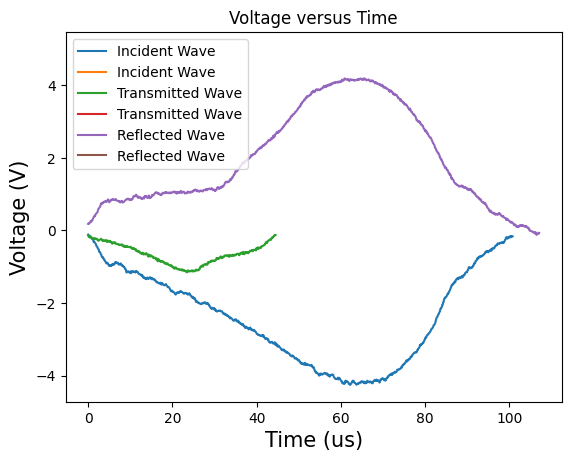

In [ ]:
# Plotting Voltage vs Time
strain_incident_voltage = voltage_signal[0]
strain_transmitted_voltage = voltage_signal[1]
strain_reflected_voltage = voltage_signal[2]

plt.figure()
plt.plot(1e6 * time, strain_incident_voltage , 5, label='Incident Wave')
plt.plot(1e6 * time, strain_transmitted_voltage , 5, label='Transmitted Wave')
plt.plot(1e6 * time, strain_reflected_voltage , 5, label='Reflected Wave')
plt.xlabel('Time (us)', fontsize=15)
plt.ylabel('Voltage (V)', fontsize=15)
plt.legend()
plt.title('Voltage versus Time')

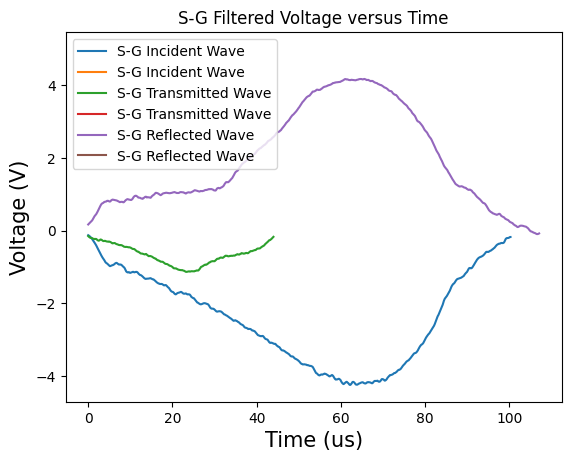

In [ ]:
voltage_signal_filtered, time_filtered, strain_filtered, stress_filtered, energy_filtered, specimen_strain_rate_filtered = kolskyStressStrain(kolsky_data_filtered, specimen_shape='cylinder', specimen_length=0.00242, specimen_depth=0.00242)

# Plotting Voltage vs Time
strain_incident_voltage_filtered = voltage_signal_filtered[0]
strain_transmitted_voltage_filtered = voltage_signal_filtered[1]
strain_reflected_voltage_filtered = voltage_signal_filtered[2]

plt.figure()
plt.plot(1e6 * time, strain_incident_voltage_filtered, 5, label='S-G Incident Wave')
plt.plot(1e6 * time, strain_transmitted_voltage_filtered, 5, label='S-G Transmitted Wave')
plt.plot(1e6 * time, strain_reflected_voltage_filtered, 5, label='S-G Reflected Wave')
plt.xlabel('Time (us)', fontsize=15)
plt.ylabel('Voltage (V)', fontsize=15)
plt.legend()
plt.title('S-G Filtered Voltage versus Time')
plt.show()

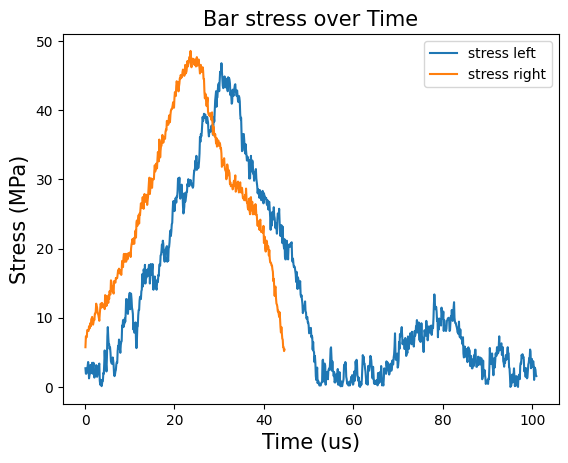

In [ ]:
#Plotting Stress Signal vs Time
stress_time_left = stress[2]
stress_time_right = stress[3]
stress_left = stress[0]
stress_right = stress[1]

plt.figure()
plt.plot(1e6 * stress_time_left * (time[1] - time[0]), stress_left/1e6, label='stress left')
plt.plot(1e6 * stress_time_right * (time[1] - time[0]), stress_right/1e6, label='stress right')
plt.xlabel('Time (us)', fontsize=15)
plt.ylabel("Stress (MPa)", fontsize=15)
plt.title('Bar stress over Time', fontsize=15)
plt.legend()
plt.show()

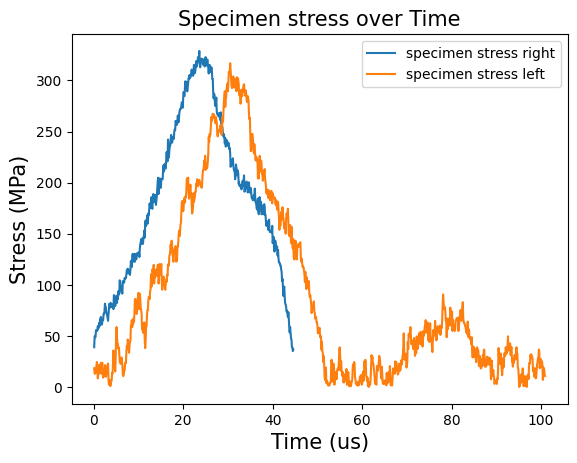

In [ ]:
#Plotting Stress vs Time
specimen_stress_left = stress[4]
specimen_stress_right = stress[5]

plt.figure()
plt.plot(1e6 * stress_time_left * (time[1] - time[0]), specimen_stress_right/1e6, label='specimen stress right')
plt.plot(1e6 * stress_time_left * (time[1] - time[0]), specimen_stress_left/1e6, label='specimen stress left')
plt.xlabel('Time (us)', fontsize=15)
plt.ylabel("Stress (MPa)", fontsize=15)
plt.title('Specimen stress over Time', fontsize=15)
plt.legend()
plt.show()

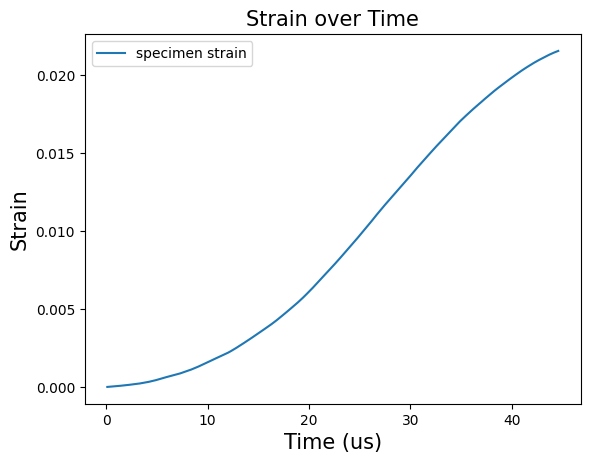

In [ ]:
#Plotting Strain rate vs Time
specimen_strain = strain[6]

plt.figure()
plt.plot(1e6 * stress_time_left * (time[1] - time[0]), specimen_strain, label='specimen strain')
plt.xlabel('Time (us)', fontsize=15)
plt.ylabel("Strain", fontsize=15)
plt.title('Strain over Time', fontsize=15)
plt.legend()
plt.show()

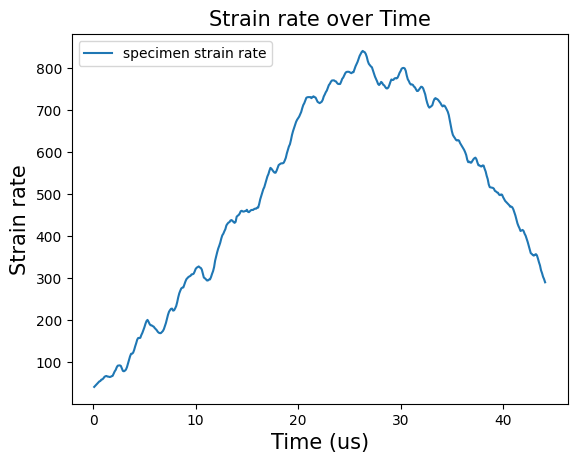

In [ ]:
#Plotting Strain rate vs Time
specimen_strain = strain[6]
specimen_strain_rate = strain_filtered[3]
plt.figure()
plt.plot(1e6 * stress_time_left * (time[1] - time[0]), specimen_strain_rate, label='specimen strain rate')
plt.xlabel('Time (us)', fontsize=15)
plt.ylabel("Strain rate", fontsize=15)
plt.title('Strain rate over Time', fontsize=15)
plt.legend()
plt.show()

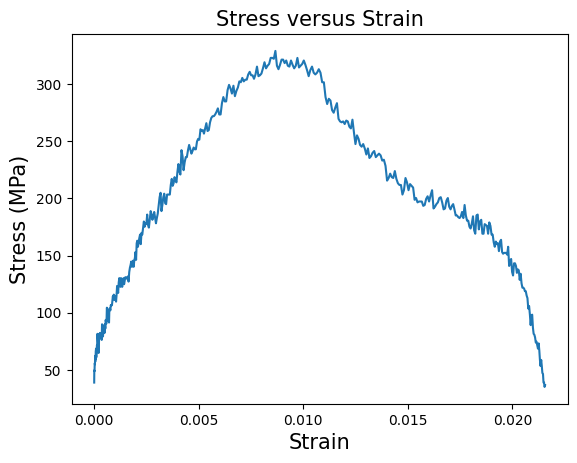

In [ ]:
#Plotting Stress vs Strain
plt.figure()
plt.plot(specimen_strain, specimen_stress_right/1e6)
plt.xlabel('Strain', fontsize=15),
plt.ylabel("Stress (MPa)", fontsize=15)
plt.title('Stress versus Strain', fontsize=15)
plt.show()

In [ ]:
file_path = '/content/drive/My Drive/1Kolsky_bar_pulverization_test_WG_104.csv'
data = {'Time (s)' : stress_time_left * (time[1] - time[0]), 'Strain': specimen_strain, 'Stress': specimen_stress_right/1e6}
df = pl.DataFrame(data)
df.write_csv(file_path)